# **MileApp Delivery Issues Prediction**

this project is made to predict whether the task is will failed or success using Random Forest machine learning model with SKLearn Library, with random forest model we could also see which variable importance and could consider the variable is the root cause of failed task, and focus on these variable.

**Project Goal**


*   predict task status and prevent the task to be fail
*   get the features importance to find the root causes.



In [12]:
import pandas as pd
import numpy as np
import json
import datetime as dt

with open('data-sample.json', 'r') as f:
    data = json.load(f)

df = pd.json_normalize(data)

# change format and additional column
df['Time_Hour'] = pd.to_datetime(df['taskCreatedTime'].str[:-9], format='%Y-%m-%d %H:%M:%S').dt.strftime('%H')
df['taskCreatedTime'] = pd.to_datetime(df['taskCreatedTime'].str[:-9], format='%Y-%m-%d %H:%M:%S').dt.strftime('%m/%d/%Y %H:%M:%S')
df['weekday'] = pd.to_datetime(df['taskCompletedTime'].str[:-9], format='%Y-%m-%d %H:%M:%S').dt.strftime('%A')
df['taskCompletedTime'] = pd.to_datetime(df['taskCompletedTime'].str[:-9], format='%Y-%m-%d %H:%M:%S').dt.strftime('%m/%d/%Y %H:%M:%S')
df['TimeCompletion_Hours'] = (pd.to_datetime(df['taskCompletedTime']) - pd.to_datetime(df['taskCreatedTime'])) / pd.Timedelta(hours=1)
df['PaymentMethod'] = df['cod.received'].apply(lambda x: 'COD' if (x == True or x == False) else 'Digital Payment')
df.to_csv("data-sample.csv")

df.head()

,taskCreatedTime,taskAssignedTo,taskCompletedTime,taskStatus,flow,taskId,taskLocationDone.lon,taskLocationDone.lat,cod.amount,cod.received,...,UserVar.receiver_city,UserVar.taskDetailStatusLabel,UserVar.taskDetailStatus,UserVar.weight,UserVar.branch_origin,UserVar.taskStatus,Time_Hour,weekday,TimeCompletion_Hours,PaymentMethod
0,11/01/2022 20:17:00,pacifiedLion0,11/01/2022 20:46:00,done,Delivery,4fe3b237c832ca4841a2,109.762910,-6.926608,685000.0,True,...,"BATANG ,KAB BATANG",YANG BERSANGKUTAN,D01,13,CGK,COLF01,20,Tuesday,0.483333,COD
1,11/01/2022 08:41:00,peacefulTacos6,11/01/2022 12:33:00,done,Delivery,08a4da25256affae8446,110.033986,-7.876154,53500.0,True,...,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,1.3,CGK,COLF01,08,Tuesday,3.866667,COD
2,11/01/2022 08:41:00,peacefulTacos6,11/01/2022 13:41:00,done,Delivery,2ff0dc469826158b7684,109.999733,-7.849777,179500.0,True,...,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,3,CGK,COLF01,08,Tuesday,5.000000,COD
3,11/01/2022 08:41:00,peacefulTacos6,11/01/2022 18:18:00,done,Delivery,331c172c2b383f774328,110.003708,-7.710998,31815.0,True,...,"PURWODADI,PURWOREJO",YANG BERSANGKUTAN,D01,0.625,CGK,COLF01,08,Tuesday,9.616667,COD
4,11/01/2022 08:41:00,peacefulTacos6,11/01/2022 10:51:00,done,Delivery,a9d53fa96c80baee8b23,110.013887,-7.829742,144562.0,True,...,"BAGELEN,PURWOREJO",YANG BERSANGKUTAN,D01,3,CGK,COLF01,08,Tuesday,2.166667,COD


# **Data Cleaning**

since the data provided limited with only 10 days, i consider not to drop rows and fill with the modus of the features or with zero

In [13]:
# data cleaning
df['cod.amount'].fillna(0, inplace = True)
df['cod.received'].fillna('Digital Payment', inplace = True)
df['cod.received'] = df['cod.received'].replace(True, 'Success')
df['cod.received'] = df['cod.received'].replace(False, 'Failed')
df['UserVar.branch_origin'].fillna(value = df['UserVar.branch_origin'].mode()[0], inplace = True)
df['UserVar.receiver_city'].fillna(value = df['UserVar.receiver_city'].mode()[0], inplace = True)
indexAge = df[df['taskStatus'] == 'ongoing'].index
df.drop(indexAge , inplace=True)
df.isna().sum()

taskCreatedTime                  0
taskAssignedTo                   0
taskCompletedTime                6
taskStatus                       0
flow                             0
taskId                           0
taskLocationDone.lon             6
taskLocationDone.lat             6
cod.amount                       0
cod.received                     0
UserVar.branch_dest              0
UserVar.taskStatusLabel          0
UserVar.receiver_city            0
UserVar.taskDetailStatusLabel    0
UserVar.taskDetailStatus         0
UserVar.weight                   0
UserVar.branch_origin            0
UserVar.taskStatus               0
Time_Hour                        0
weekday                          6
TimeCompletion_Hours             6
PaymentMethod                    0
dtype: int64

# **Feature Selection**
Feature selection methods are intended to reduce the number of input variables to those that are believed to be most useful to a model in order to predict the target variable. the features we used are :


*   taskAssignedTo
*   cod.amount
*   UserVar.branch_dest
*   UserVar.receiver_city
*   UserVar.weight  
*   UserVar.branch_origin
*   weekday
*   Time_Hour
*   PaymentMethod












In [14]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder


# Preprocessing
# Multiple categorical columns
categorical_cols = ['taskAssignedTo','UserVar.branch_dest', 'UserVar.receiver_city','UserVar.branch_origin', 'PaymentMethod', 'weekday', 'Time_Hour']

categorical_data = df[categorical_cols]

labelencoder = LabelEncoder()
features = categorical_data.apply(LabelEncoder().fit_transform)
temp = df[['cod.amount','UserVar.weight','UserVar.taskStatusLabel']]
data = pd.merge(features, temp, left_index=True, right_index=True)
data

,taskAssignedTo,UserVar.branch_dest,UserVar.receiver_city,UserVar.branch_origin,PaymentMethod,weekday,Time_Hour,cod.amount,UserVar.weight,UserVar.taskStatusLabel
0,1844,50,137,12,0,5,12,685000.0,13,Success
1,1896,31,1266,12,0,5,1,53500.0,1.3,Success
2,1896,31,1266,12,0,5,1,179500.0,3,Success
3,1896,31,1266,12,0,5,1,31815.0,0.625,Success
4,1896,31,66,12,0,5,1,144562.0,3,Success
...,...,...,...,...,...,...,...,...,...,...
8329,688,12,1090,12,1,4,2,0.0,1,Success
8330,1708,23,747,51,1,4,2,0.0,1,Failed
8331,877,56,923,12,1,4,2,0.0,1.44,Success
8332,1561,26,739,12,0,4,0,151000.0,0.6,Failed


In [15]:
# Split the data into features (X) and target (y)

X = data.drop(['UserVar.taskStatusLabel'], axis=1)
y = data['UserVar.taskStatusLabel']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=3)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 15, 'n_estimators': 441}


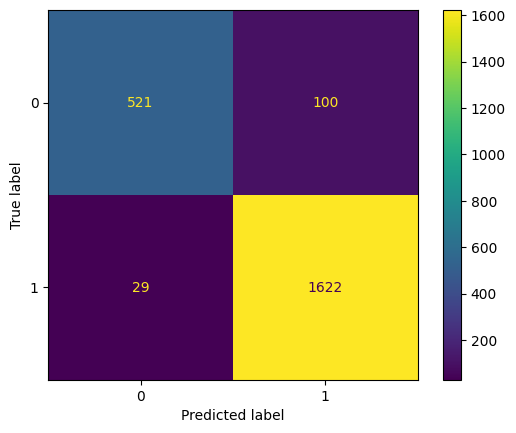

In [16]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [17]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label="Success")
recall = recall_score(y_test, y_pred, pos_label="Success")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9432218309859155
Precision: 0.9419279907084785
Recall: 0.982434887946699


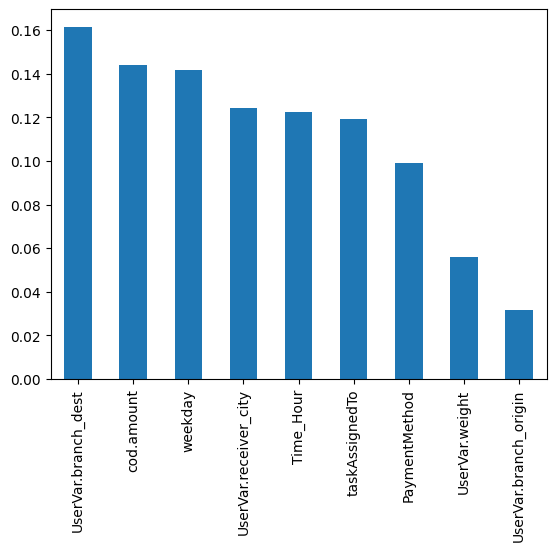

In [18]:
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

# **Result**

the result shows we have good accuracy received **94%**, it would be better if we have additional history data to help the learning model. 
by this model we could use as an prevention action to give extra attention that will be predicted "failed", so could increase the deliveries success rate, minimizae the risk and get customer satisfaction.

we found out that the highest features importance are **uservar.branch_dest, cod.amount and weekday**, we could conclude the taskCreatedTime and branchdest are the most imporatance features. by knowing the root cause of failed task, we could solve the issues efficiently.

In [ ]:
#unique, counts = np.unique(y_test, return_counts=True)
#print(unique, counts)

In [ ]:
""")
# Split the data into features (X) and target (y)

X = data.drop(['UserVar.taskStatusLabel'], axis=1)
y = data['UserVar.taskStatusLabel']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy*100,"%")
("""

In [ ]:
""")
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder


#Preprocessing
# Multiple categorical columns
categorical_cols = ['taskAssignedTo','cod.received','UserVar.branch_dest', 'UserVar.receiver_city', 'UserVar.taskDetailStatus','UserVar.branch_origin', 'PaymentMethod']

categorical_data = df[categorical_cols]

ohe = OneHotEncoder(categories='auto')
feature_arr = ohe.fit_transform(categorical_data).toarray()
ohe_labels = ohe.get_feature_names_out(categorical_cols)
features = pd.DataFrame(feature_arr,columns=ohe_labels)
temp = df[['cod.amount','UserVar.weight','UserVar.taskStatusLabel']].reset_index()
data = pd.merge(features, temp, left_index=True, right_index=True)
data
("""